Spark project

In [17]:
#conda install -c cyclus java-jdk
#!pip install py4j
import os 
import sys
''' the following lines are to make pyspark work with jupyter notebook in my case '''
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [18]:
# !pip install praw
# !pip install textblob
# !pip install pyspark

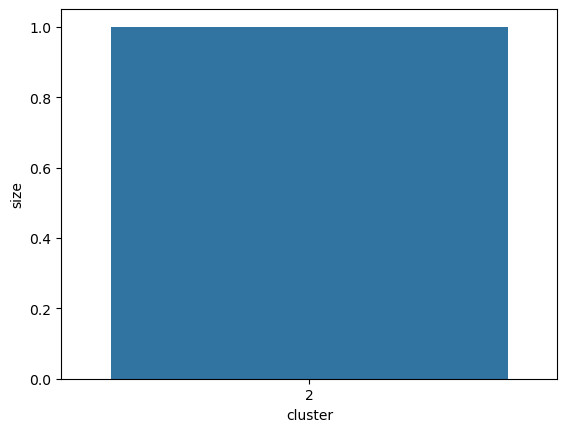

In [19]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from textblob import TextBlob
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.mllib.linalg import Vectors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time

In [ ]:
# Create a SparkContext
#sc = SparkContext(appName="RedditStreamingSentimentAnalysis")
sc=SparkContext.getOrCreate()
sc.setCheckpointDir("checkpoint_spark") # set checkpoint directory to use windowed operations

In [ ]:
sc.setLogLevel("ERROR")

In [ ]:
# Create a StreamingContext with a batch interval of 10 seconds
ssc = StreamingContext(sc, 10)

#ssc.checkpoint("checkpoint") # set checkpoint directory to use windowed operations

c:\Users\junio\anaconda3\lib\site-packages\pyspark\streaming\context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


In [ ]:
# Create a DStream from the socket
dstream = ssc.socketTextStream("localhost", 8888)

In [ ]:
subr_to_int = {}

def process_messages(messages):
    message = json.loads(messages)
    
    # for the label encoder  
    if message['subreddit'] not in subr_to_int:
        subr_to_int[message['subreddit']] = len(subr_to_int)
       
    # sentiment analysis
    polarity, subjectivity = TextBlob(message['text']).sentiment
    return {
        'text':message['text'],
        'subreddit':subr_to_int[message['subreddit']],
        'polarity':polarity,
        'subjectivity':subjectivity
    }

In [ ]:

# Define a function to perform sentiment analysis on each message
#def analyze_sentiment(message):
    #blob = TextBlob(message)
    #polarity = blob.sentiment.polarity
    #subjectivity = blob.sentiment.subjectivity
    #if polarity > 0:
    #    sentiment = "positive"
    #elif polarity < 0:
    #    sentiment = "negative"
    #else:
    #    sentiment = "neutral"
    #return (message,sentiment,polarity)
    # return (sentiment,1)

In [ ]:
# Apply the sentiment analysis function to each message in the DStream
tagged_dstream = dstream.filter(lambda line: len(line) > 0)\
                        .map(lambda message: process_messages(message))
#tagged_dstream = dstream.map(lambda message: analyze_sentiment(message))
                        # .reduceByKey(lambda a, b: a + b)
# .flatMap(lambda line: line.split(" "))\
# .map(lambda line: line.split("|"))\

# Print the results
#tagged_dstream.pprint()


In [ ]:
train_data = tagged_dstream.map(lambda line: Vectors.dense([line['polarity'], line['subjectivity'], line['subreddit']]))

#train_data.pprint()

#train_data=tagged_dstream.map(lambda line: line[2])
#train_data.pprint()

# Build a K-Means clustering model
# model = StreamingKMeans(k=3, decayFactor=1.0).setRandomCenters(2, 1.0, 0)

# Use the model to make predictions
# predictions = model.predictOnValues(train_data.map(lambda x: (x, x)))

# Print the predicted cluster assignments
# predictions.pprint()

clustering

In [ ]:
n_features = 3
model = StreamingKMeans(k=3, decayFactor=1.0).setRandomCenters(n_features, 1.0, 0)

model.trainOn(train_data)
result = model.predictOn(train_data)
#result.pprint()

windows

In [ ]:
pairs =result.map(lambda x: (x, 1))
#pairs = result.map(lambda cluster: (f'cluster-{cluster+1}', 1))
#pairs.pprint()
clusterCounts = pairs.reduceByKeyAndWindow(lambda x, y: x + y, lambda x, y: x - y, 30, 10)
clusterCounts.pprint()

In [ ]:
# # For debugging purposes (to check if we receive correctly the data)
# counts = dstream.flatMap(lambda line: line.split(" "))\
#                 .filter(lambda word: len(word) > 0)\
#                 .map(lambda word: (word, 1))\
#                 .reduceByKey(lambda a, b: a + b)
# counts.pprint()

In [ ]:
def plot_cluster_sizes(rdd):
    df = pd.DataFrame(rdd.collect(), columns=["cluster", "size"])
    sns.barplot(x="cluster", y="size", data=df)
    plt.show()

# Visualize the cluster sizes in sliding windows
clusterCounts.foreachRDD(lambda rdd: plot_cluster_sizes(rdd))

Py4JJavaError: An error occurred while calling o23.awaitTermination.
: org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "c:\Users\junio\anaconda3\lib\site-packages\pyspark\streaming\util.py", line 71, in call
    r = self.func(t, *rdds)
  File "c:\Users\junio\anaconda3\lib\site-packages\pyspark\streaming\dstream.py", line 236, in func
    return old_func(rdd)  # type: ignore[call-arg, arg-type]
  File "C:\Users\junio\AppData\Local\Temp\ipykernel_26184\2869648346.py", line 7, in <lambda>
    pairs.foreachRDD(lambda rdd: plot_cluster_sizes(rdd))
  File "C:\Users\junio\AppData\Local\Temp\ipykernel_26184\2869648346.py", line 3, in plot_cluster_sizes
    sns.barplot(x="cluster", y="size", data=df)
  File "c:\Users\junio\anaconda3\lib\site-packages\seaborn\categorical.py", line 2755, in barplot
    plotter = _BarPlotter(x, y, hue, data, order, hue_order,
  File "c:\Users\junio\anaconda3\lib\site-packages\seaborn\categorical.py", line 1532, in __init__
    self.establish_colors(color, palette, saturation)
  File "c:\Users\junio\anaconda3\lib\site-packages\seaborn\categorical.py", line 707, in establish_colors
    lum = min(light_vals) * .6
ValueError: min() arg is an empty sequence

	at org.apache.spark.streaming.api.python.TransformFunction.callPythonTransformFunction(PythonDStream.scala:95)
	at org.apache.spark.streaming.api.python.TransformFunction.apply(PythonDStream.scala:78)
	at org.apache.spark.streaming.api.python.PythonDStream$.$anonfun$callForeachRDD$1(PythonDStream.scala:179)
	at org.apache.spark.streaming.api.python.PythonDStream$.$anonfun$callForeachRDD$1$adapted(PythonDStream.scala:179)
	at org.apache.spark.streaming.api.python.PythonDStream$$$Lambda$907/2020242030.apply(Unknown Source)
	at org.apache.spark.streaming.dstream.ForEachDStream.$anonfun$generateJob$2(ForEachDStream.scala:51)
	at org.apache.spark.streaming.dstream.ForEachDStream$$Lambda$1407/1906194631.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.streaming.dstream.DStream.createRDDWithLocalProperties(DStream.scala:417)
	at org.apache.spark.streaming.dstream.ForEachDStream.$anonfun$generateJob$1(ForEachDStream.scala:51)
	at org.apache.spark.streaming.dstream.ForEachDStream$$Lambda$1394/155958625.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.streaming.scheduler.Job.run(Job.scala:39)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler.$anonfun$run$1(JobScheduler.scala:256)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler$$Lambda$1406/1253287367.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler.run(JobScheduler.scala:256)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)


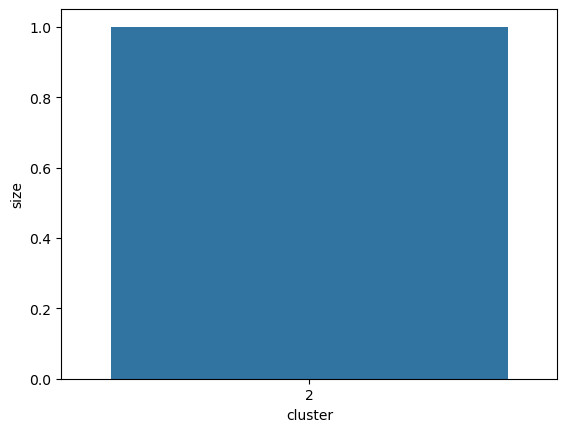

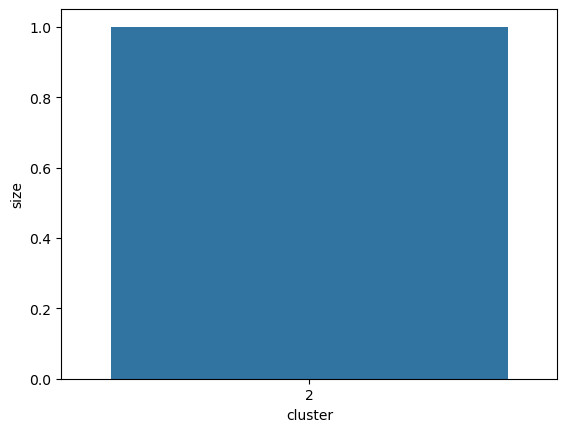

In [ ]:
# Start the streaming context
ssc.start()
# Wait for the streaming to finish
ssc.awaitTermination()

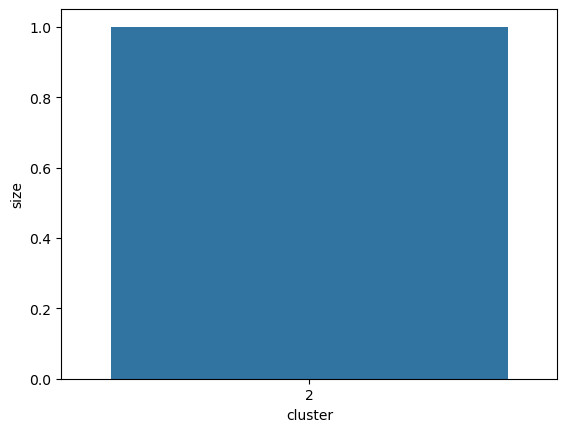

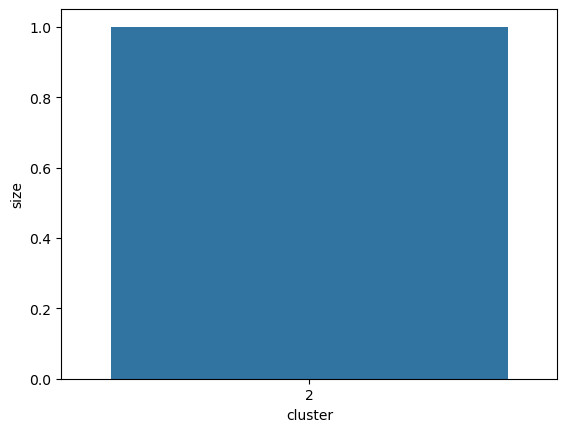

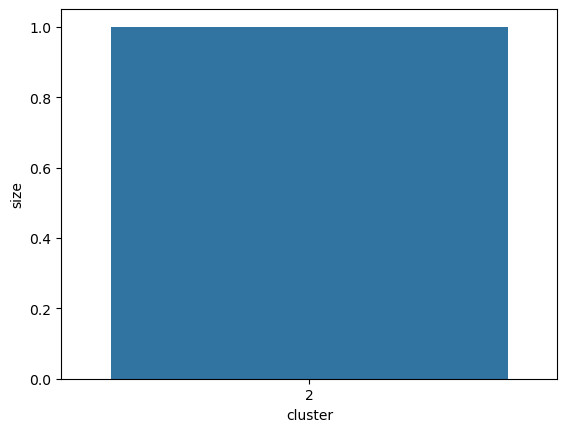

In [20]:
ssc.stop(stopSparkContext=True, stopGraceFully=True)